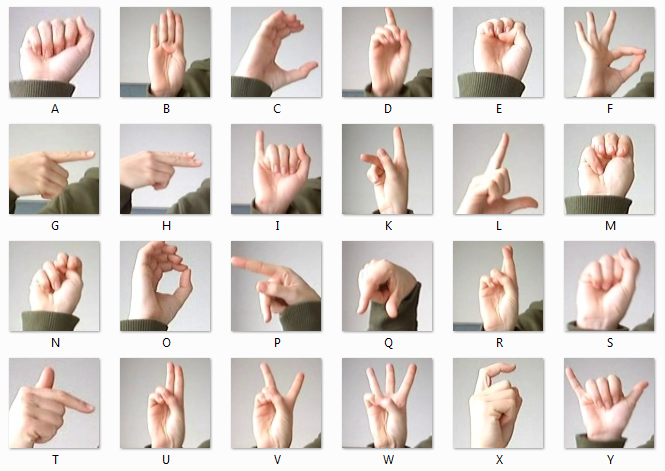

# Description
The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To stimulate the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
print(os.listdir("../input/sign-language-mnist"))

In [ ]:
train = pd.read_csv('../input/sign-language-mnist/sign_mnist_train.csv')
test = pd.read_csv('../input/sign-language-mnist/sign_mnist_test.csv')

In [ ]:
train.shape

In [ ]:
labels = train['label']

In [ ]:
labels

In [ ]:
train = train.drop('label',axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
x_train = train/255.0

In [ ]:
x_train.shape

In [ ]:
x_train = x_train.values.reshape(-1,28,28,1)   # 第一个维度不管，不用变；后面变为28,28,1
#test = test.values.reshape(-1,28,28,1)

In [ ]:
labels.value_counts()

In [ ]:
labels = to_categorical(labels,num_classes=25)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.3, random_state = 2)

In [ ]:
plt.imshow(x_train[0][:,:,0])

In [ ]:
from keras import layers
from keras import models

In [ ]:
model = models.Sequential()
model = Sequentialmodel = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(25, activation = "softmax"))

In [ ]:
model.compile(optimizer = Adam() , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 40
batch_size = 50

In [ ]:
datagen = ImageDataGenerator(         # 用于数据增强
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(25)) 

In [ ]:
test_labels = test['label']
test.drop('label', axis = 1, inplace = True)
test_images = test.values/255.0
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])
test_labels = to_categorical(test_labels,num_classes=25)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
y_pred = model.predict(test_images)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, y_pred.round())

In [ ]:
# predict results
#results = model.predict(test)

# select the indix with the maximum probability
#results = np.argmax(results,axis = 1)

#results = pd.Series(results,name="Label")

In [ ]:
#submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

#submission.to_csv("sign_language.csv",index=False)